# BE m228 Final Project

### Import Libraries

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import shap

C:\Users\schow\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Processing

**Gut Health Data**

In [16]:
microbiome = pd.read_csv('data/gut_health_test.csv')
microbiome.dropna(inplace=True)

microbiome.head(3)

,subject,Gut Lining Health,LPS Biosynthesis Pathways,"Biofilm, Chemotaxis, and Virulence Pathways",TMA Production Pathways,Ammonia Production Pathways,Metabolic Fitness,Active Microbial Diversity,Butyrate Production Pathways,Flagellar Assembly Pathways,...,Inflammatory Activity,Gut Microbiome Health,Digestive Efficiency,Protein Fermentation,Gas Production,Methane Gas Production Pathways,Sulfide Gas Production Pathways,Oxalate Metabolism Pathways,Salt Stress Pathways,Microbiome-Induced Stress
0,1,2.0,2.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,...,2.0,3.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,2.0
1,2,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0
2,3,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0,3.0,2.0


I dropped any rows with missing values which leaves us only with 42 participants. 

- subjects with missing vals: 26, 28, 48
- already dropped: 24, 25, 37, 40

**Demographics Data**

In [17]:
demographics = pd.read_csv('data/bio.csv')
demographics = demographics[['subject', 'Age', 'Gender', 'BMI', 'Height ', 'Body weight ', 'Self-identify ', 'A1c PDL (Lab)', 'Fasting GLU - PDL (Lab)', 'Insulin ', 'Triglycerides', 'Cholesterol']]
demographics.columns = ['ID', 'Age', 'Gender', 'BMI', 'Weight', 'Height', 'Race', 'A1c', 'Fasting Glucose', 'Insulin', 'Triglycerides', 'Cholesterol']

# drop those participants identified above that had missing data in the microbiome dataset
demographics = demographics[~demographics['ID'].isin([26, 28, 48])]

In [28]:
# defining if patient is diabetic, pre-diabetic, or not diabetic based on A1c levels
def diabetic_status(a1c):
    if a1c < 5.7:
        return 'Not Diabetic'
    elif 5.7 <= a1c <= 6.4:
        return 'Pre-Diabetic'
    else:
        return 'Diabetic'

demographics['Diabetic Status'] = demographics['A1c'].apply(diabetic_status)
demographics.head(3)

,ID,Age,Gender,BMI,Weight,Height,Race,A1c,Fasting Glucose,Insulin,Triglycerides,Cholesterol,Diabetic Status
0,1,27,M,22.265239,65.0,133.8,Hispanic/Latino,5.4,91,2.5,67,216,Not Diabetic
1,2,49,F,30.946742,62.0,169.2,Hispanic/Latino,5.5,93,14.8,61,181,Not Diabetic
2,3,59,F,26.948690,64.0,157.0,Hispanic/Latino,6.5,118,17.4,154,190,Diabetic


### Exploratory Data Analysis

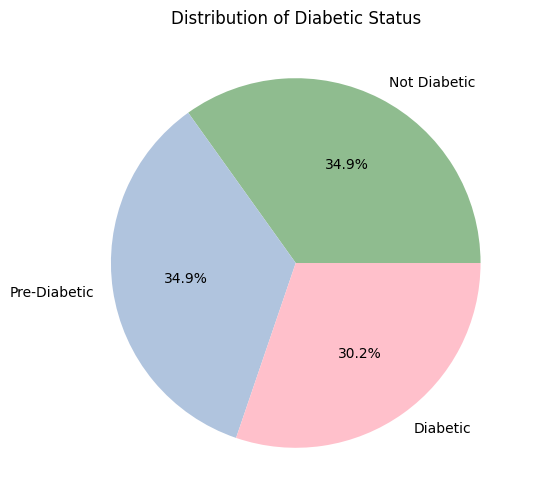

In [7]:
diabetic_counts = demographics['Diabetic Status'].value_counts()

plt.figure(figsize=(8, 6))
diabetic_counts.plot(kind='pie', autopct='%1.1f%%', colors=['darkseagreen', 'lightsteelblue', 'pink'])
plt.title('Distribution of Diabetic Status')
plt.ylabel('')
plt.show()


In [40]:
print(diabetic_counts)

Diabetic Status
Not Diabetic    15
Pre-Diabetic    15
Diabetic        13
Name: count, dtype: int64


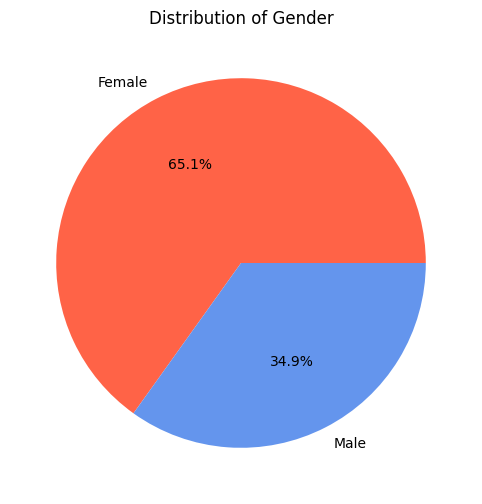

In [8]:
gender_counts = demographics['Gender'].value_counts()

plt.figure(figsize=(8, 6))
gender_counts.plot(kind='pie', autopct='%1.1f%%', labels=['Female', 'Male'], colors=['tomato', 'cornflowerblue'])
plt.title('Distribution of Gender')
plt.ylabel('')
plt.show()

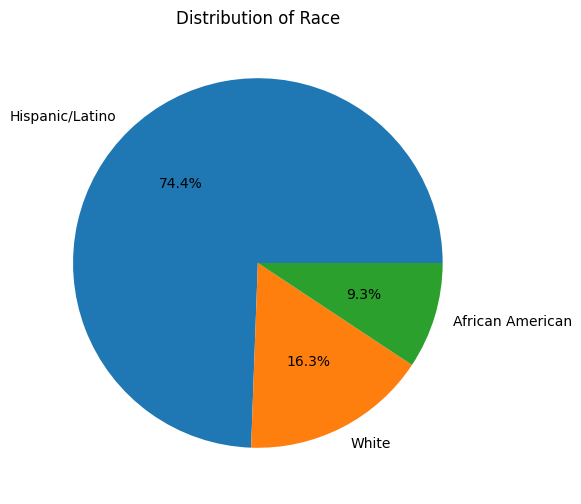

In [9]:
# cleaning up data
def race(value):
    if value == 'Black, African American':
        return 'African American'
    else:
        return value
demographics['Race'] = demographics['Race'].apply(race)

# visualizing distribution
race_counts = demographics['Race'].value_counts()

plt.figure(figsize=(8, 6))
race_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Race')
plt.ylabel('')
plt.show()

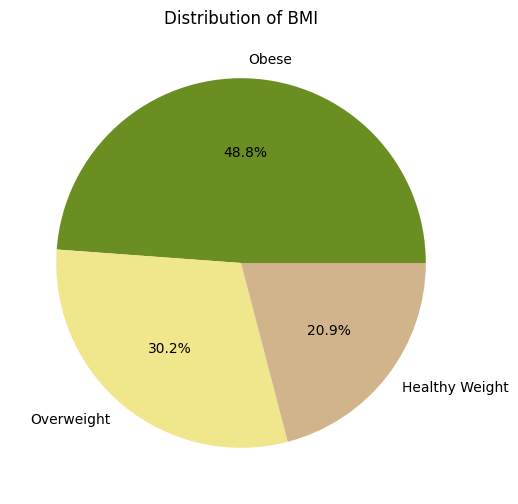

In [10]:
# BMI interpretation (healthy, overweight, obese) based on BMI values - NOTE change to be specific to height/gender
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Healthy Weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'
demographics['BMI Category'] = demographics['BMI'].apply(bmi_category)


# visualizing distribution
bmi_counts = demographics['BMI Category'].value_counts()

plt.figure(figsize=(8, 6))
bmi_counts.plot(kind='pie', autopct='%1.1f%%' , colors=['olivedrab', 'khaki', 'tan', 'lightyellow'])
plt.title('Distribution of BMI')
plt.ylabel('')
plt.show()

**Participant One Example**

In [11]:
participant_one = pd.read_csv('participants/CGMacros-001.csv')
participant_one.head(3)

,Unnamed: 0,Timestamp,Libre GL,Dexcom GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed,Image path
0,0,2020-05-01 10:30:00,84.000000,NaN,56.0,1.0484,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-05-01 10:31:00,84.133333,NaN,56.0,1.0484,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-05-01 10:32:00,84.266667,NaN,57.0,1.0484,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


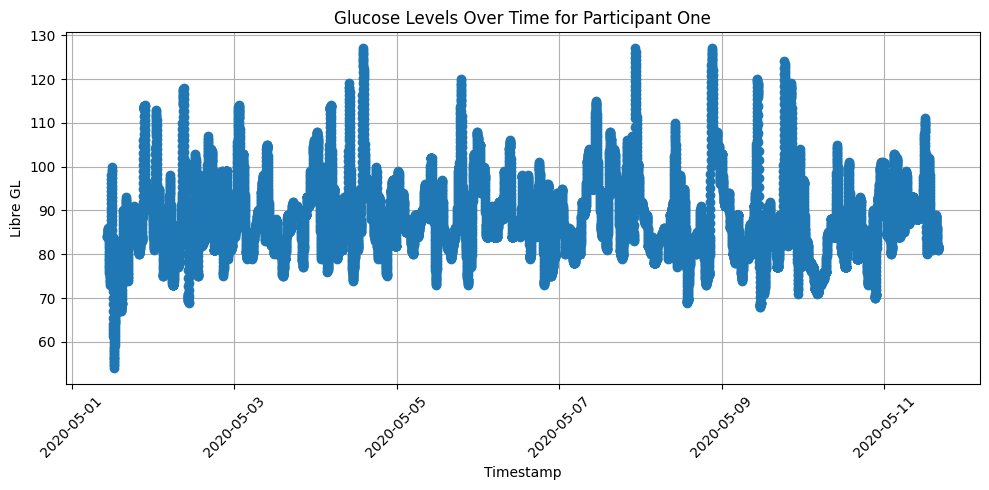

In [12]:
# transform timestamp column to datetime format
participant_one['Timestamp'] = pd.to_datetime(participant_one['Timestamp'])
# plotting glucose levels 'Libre GL' for participant_one    
plt.figure(figsize=(10, 5))
plt.plot(participant_one['Timestamp'], participant_one['Libre GL'], marker='o')
plt.title('Glucose Levels Over Time for Participant One')
plt.xlabel('Timestamp')
plt.ylabel('Libre GL')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

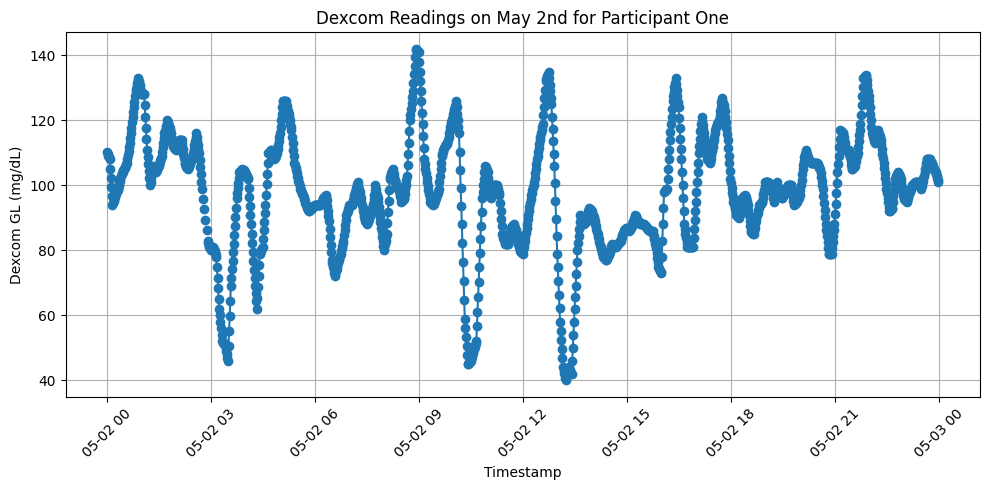

In [13]:
# plotting glucose data for participant_one only for day one (2020-05-01)
participant_one_day_one = participant_one[participant_one['Timestamp'].dt.date == pd.to_datetime('2020-05-02').date()]
plt.figure(figsize=(10, 5))
plt.plot(participant_one_day_one['Timestamp'], participant_one_day_one['Dexcom GL'], marker='o')
plt.title('Dexcom Readings on May 2nd for Participant One')
plt.xlabel('Timestamp')
plt.ylabel('Dexcom GL (mg/dL)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

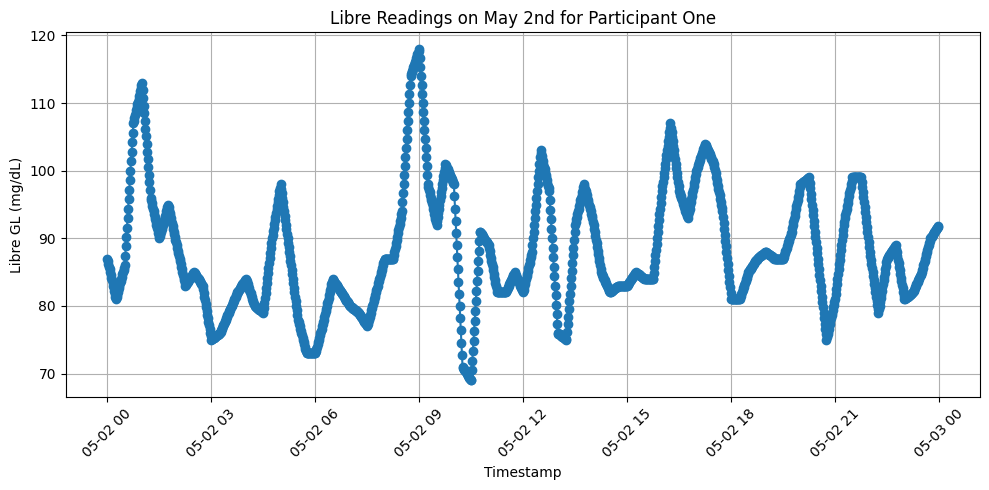

In [14]:
# plotting glucose data for participant_one only for day one (2020-05-01)
participant_one_day_one = participant_one[participant_one['Timestamp'].dt.date == pd.to_datetime('2020-05-02').date()]
plt.figure(figsize=(10, 5))
plt.plot(participant_one_day_one['Timestamp'], participant_one_day_one['Libre GL'], marker='o')
plt.title('Libre Readings on May 2nd for Participant One')
plt.xlabel('Timestamp')
plt.ylabel('Libre GL (mg/dL)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### Random Forest Model

In [ ]:
X = microbiome.drop(columns=['subject']) # drop id column (don't want to use as feature)
y = demographics['Diabetic Status']      # col we want to predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Diabetic       0.00      0.00      0.00         5
Not Diabetic       0.25      0.50      0.33         2
Pre-Diabetic       0.00      0.00      0.00         2

    accuracy                           0.11         9
   macro avg       0.08      0.17      0.11         9
weighted avg       0.06      0.11      0.07         9



C:\Users\schow\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\schow\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\schow\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

- precision: when label is predicted, how often is it correct? 
  - minimize false positives
- recall: how many of the positives were actually predicted?
  - minimize false negatives
- f1 score: balance of precision and recall
- support: 

In [ ]:
# confusion matrix - diagonal elements represent correct classifications, off-diagonal elements represent misclassifications
print(confusion_matrix(y_test, y_pred))

[[0 1 4]
 [0 1 1]
 [0 2 0]]


In [ ]:
# feature importance (doesn't indicate direction)
importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

Putrescine Production Pathways                 0.085781
Flagellar Assembly Pathways                    0.069021
Gas Production                                 0.065923
Uric Acid Production Pathways                  0.061455
Ammonia Production Pathways                    0.058787
Gut Microbiome Health                          0.054821
Biofilm, Chemotaxis, and Virulence Pathways    0.052537
Salt Stress Pathways                           0.050953
TMA Production Pathways                        0.049649
Active Microbial Diversity                     0.046262
Metabolic Fitness                              0.046091
LPS Biosynthesis Pathways                      0.040436
Protein Fermentation                           0.039750
Digestive Efficiency                           0.039312
Bile Acid Metabolism Pathways                  0.037960
Butyrate Production Pathways                   0.035433
Sulfide Gas Production Pathways                0.033049
Microbiome-Induced Stress                      0

In [37]:
# AUC score 
roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr")

0.6166666666666667

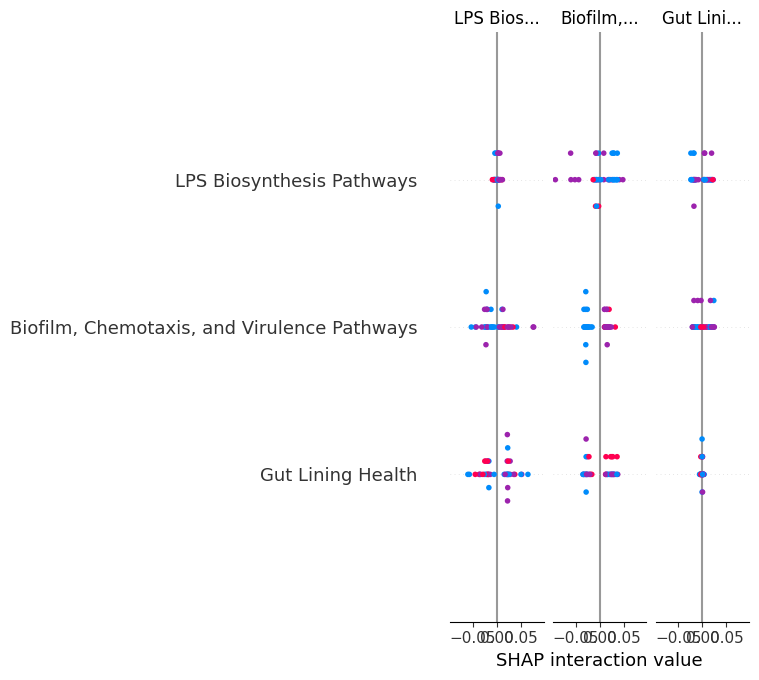

In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)